# Classificador de PPAP(Pen, Pineapple, Apple, Apple, Pen)

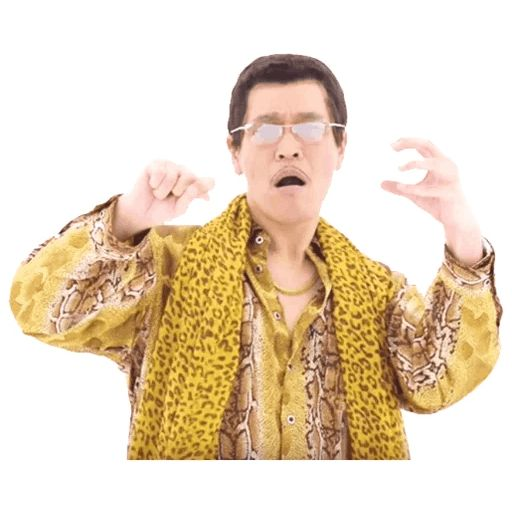

> Uh! Pen-pineapple-apple-pen

### Você já se confundiu ao ouvir essa música ?

Bom, se você já se confundiu com esse japonês falando tantas coisas parecidas e ao mesmo tempo nessa música?

Então você está no lugar certo, através de aprendizado de máquina eu criei exatamente o que você precisava, um classificador de Apple(maçã), Pen(Caneta), Pineapple(Abacaxi), embora muito se pareçam as palavras em inglês elas representam coisas distinstas.

Vejamos então!

### Instalando dependências

Vamos começar instalando as dependências necessárias utilizando o gerenciador de pacotes pip, note que comandos iniciados com ! siginifica códigos executados no terminal.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

Para fazer o download necessário das imagens utilizaremos por padrão o DDG(DuckDuckGo Search)

In [3]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

Aqui faremos um Download de exemplo, veja que com a função len(), ela retorna 200, que é o tamanho padrão da função search_images_ddg

Observe que apresentamos o resultado através da função im.to_thumb()

In [4]:
ims = search_images_ddg('pineapple')
len(ims)

200

In [5]:
dest = 'images/pineapple.jpg'
download_url(ims[0], dest, show_progress=False)

Path('images/pineapple.jpg')

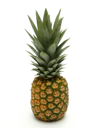

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

## Separação das categorias de datasets

Para treinar a rede nós necessitaremos de 3 tipos de dados, são eles: Canetas, Abacaxis e Maçãs.
Você pode ver abaixo a função que separa e faz o download das imagens.

In [7]:
PPAP = 'pen', 'pineapple', 'apple'
path = Path('ppap')

In [8]:
if not path.exists():
    path.mkdir()
    for o in PPAP:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o}')
        download_images(dest, urls=results)

Esta função retornará para nós uma lista com o caminho de cada imagem, que será utilizado no treinamento posteriormente

In [9]:
fns = get_image_files(path)
fns

(#555) [Path('ppap/apple/0014e4d1-3e28-4da4-ab98-1170c9a585e8.jpg'),Path('ppap/apple/013ec52f-68a8-43e7-8230-f115a2fd955c.jpg'),Path('ppap/apple/0142f21e-dabe-419d-b143-442ca0dd5493.jpg'),Path('ppap/apple/0335b63d-acc2-4733-8a2f-2c7c1e63b5a3.jpg'),Path('ppap/apple/07cf8791-5f06-4978-8738-266438085dbd.jpg'),Path('ppap/apple/0bf347c7-0f33-4cc2-b32c-c8fe9e14cf8e.jpg'),Path('ppap/apple/0edf557d-6a25-44df-8f31-d8df4bac6312.jpg'),Path('ppap/apple/0ee96be9-0cde-4494-8d9d-2d17b247d486.jpg'),Path('ppap/apple/129d1129-cfea-4657-9fe6-6be18e0736e0.jpg'),Path('ppap/apple/12cd1d72-5d5c-4fa8-848d-627711dab4dd.jpg')...]

Nesta função verify_images ele retornará uma lista de imagens com erro, nesse caso não tinha nenhuma, por isso o número 0

In [10]:
failed = verify_images(fns)
failed

(#0) []

## Preparando o DataBlock

Como você viu no notebook anterior, nós trataremos os dados do dataloaders utilizando os mesmos parâmetros anteriores.
A diferença que trataremos as imagens de uma forma diferente desta vez, você vai ver mais adiante !

In [11]:
ppap = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


In [12]:
dls = ppap.dataloaders(path)

C:\Users\Mateus\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


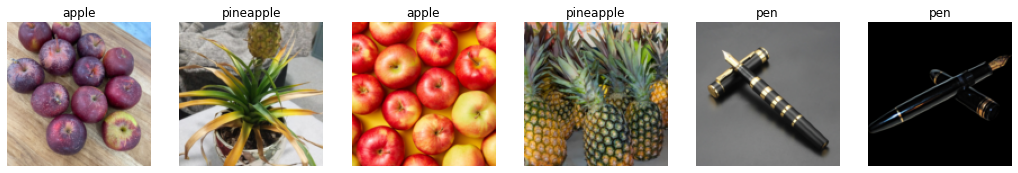

In [13]:
dls.valid.show_batch(max_n=6, nrows=1)

## Mudando algumas imagens

Bom, aqui começam algumas mudanças que diferem do código anterior, note que passamos agora para o dataloader a mesma imagem, porém utilizando o método ResizeMethod.Squish, ele faz um redimensionamento na imagem para que os nós da rede possam aprender, sem perder dados(sem algum método de resize alguns modelos de rede só conseguem analisar uma quantidade de pixels pré definida).

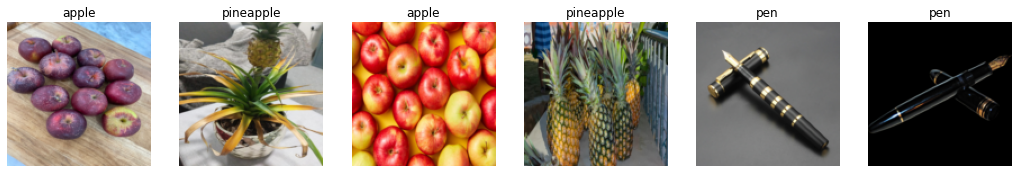

In [14]:
ppap = ppap.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = ppap.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=1)

Já com esse método `ResizeMethod.Pad, pad_mode='zeros'` ele diminui o tamanho da imagem e preenche com a cor preta `pad_mode='zeros'`

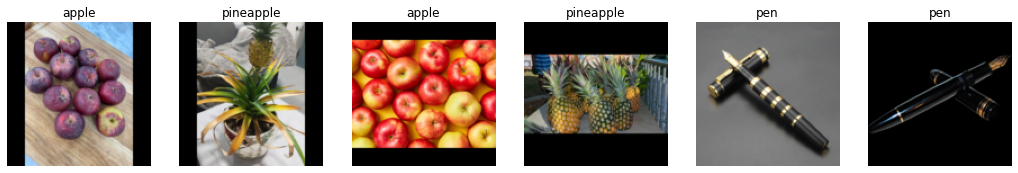

In [15]:
ppap = ppap.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = ppap.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=1)

Com o `RandomResizedCrop(128, min_scale=0.3)` ele faz recortes aleatório na imagem para redimensionar o tamanho

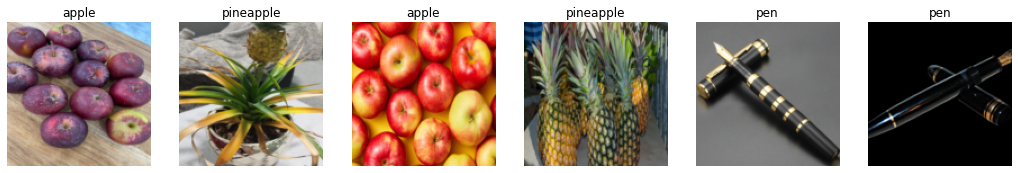

In [16]:
ppap = ppap.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = ppap.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=1)

Aqui um dos mais interessantes métodos de modificação de imagem `batch_tfms=aug_transforms()` ele promove algumas alterações como saturação, rotação, espelhamento, mudança de brilho, mudança de contraste. Promove diferenças nas imagens, mas não muda seu significado.

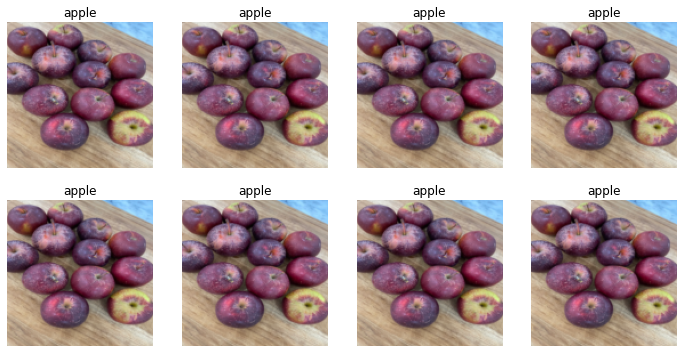

In [17]:
ppap = ppap.new(item_tfms=RandomResizedCrop(128), batch_tfms=aug_transforms())
dls = ppap.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)


Aqui será o nosso dataloader que utilizaremos para treinar nosso modelo.

In [21]:
ppap = ppap.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = ppap.dataloaders(path)

## Definido nossos dados, vamos treinar nosso modelo.

Utilizaremos a `resnet18` para treinar nosso modelo e por se tratarem de imagens distintas e que se diferem bastante vamos utilzar apenas 4 épocas de `fine_tune()`.

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.109698,0.048383,0.020833,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.171800,0.054862,0.020833,00:34
1,0.124436,0.063942,0.020833,00:33
2,0.088134,0.061714,0.020833,00:33
3,0.067274,0.063545,0.020833,00:34


Como explicado, as imagens já se diferem bastantante e nosso modelo já começa com uma taxa de erro muito baixo, que permanece constante.

## Fazendo uma análise do treinamento

Abaixo nós utilizaremos uma matriz de confusão para fazer uma análise mais apurada do treinamento, aqui poderemos ver quantas classificações foram feitas de forma errada e qual a predição para a resposta válida.

Note que na diagonal principal estão os dados acertados corretamente e fora, a predição e o dado válido.

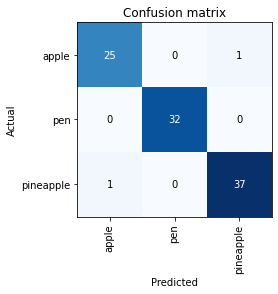

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Abaixo você pode ver as piores predições, ou seja, aquelas que ele classificou de forma errada de acordo com o rótulo ou com uma chance baixa de acerto.
E é feito através da função `plot_top_losses()`.

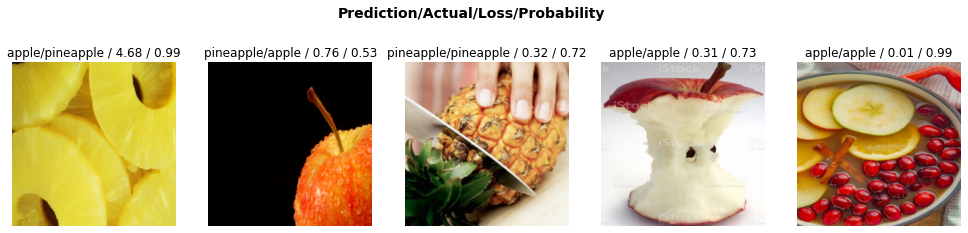

In [24]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

## Limpando dados

Como você pode ver a primeira imagem acima apresenta uma imagem que não corresponde a exatamente o que nós gostaríamos de abacaxis, lembre-se essas imagens foram buscadas diretamente do duck duck go utilizando a função `search_images_ddg()`, portanto não é improvável que venham algumas imagens com erros, ou falhas. 
Para evitar problemas e treinamentos errados podemos limpar essas imagens através da função abaixo `ImageClassifierCleaner()`.

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Note que essa função na verdade não limpa ou apaga os arquivos do diretório, ela apenas muda os rótulos, para limpar as imagens utilizaremos a função abaixo:

In [26]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Exportando nosso modelo

Ficar apenas no notebook local é muito bom, porém para nossa rede neural conquistar o mundo precisamos exportá-la e fazer um deploy no Hugging Face.

É utilizando a função `export()` que faremos a exportação do nosso modelo treinado, podendo utilizá-lo em qualquer lugar.

In [27]:
learn.export('model.pkl')

## Deploy

Utilizando o Hugging Face eu já fiz o deploy deste notebook para você classificar quantas maçãs, abacaxis e canetas que você quiser, confira através do link: https://huggingface.co/spaces/mateus-lm/ppap

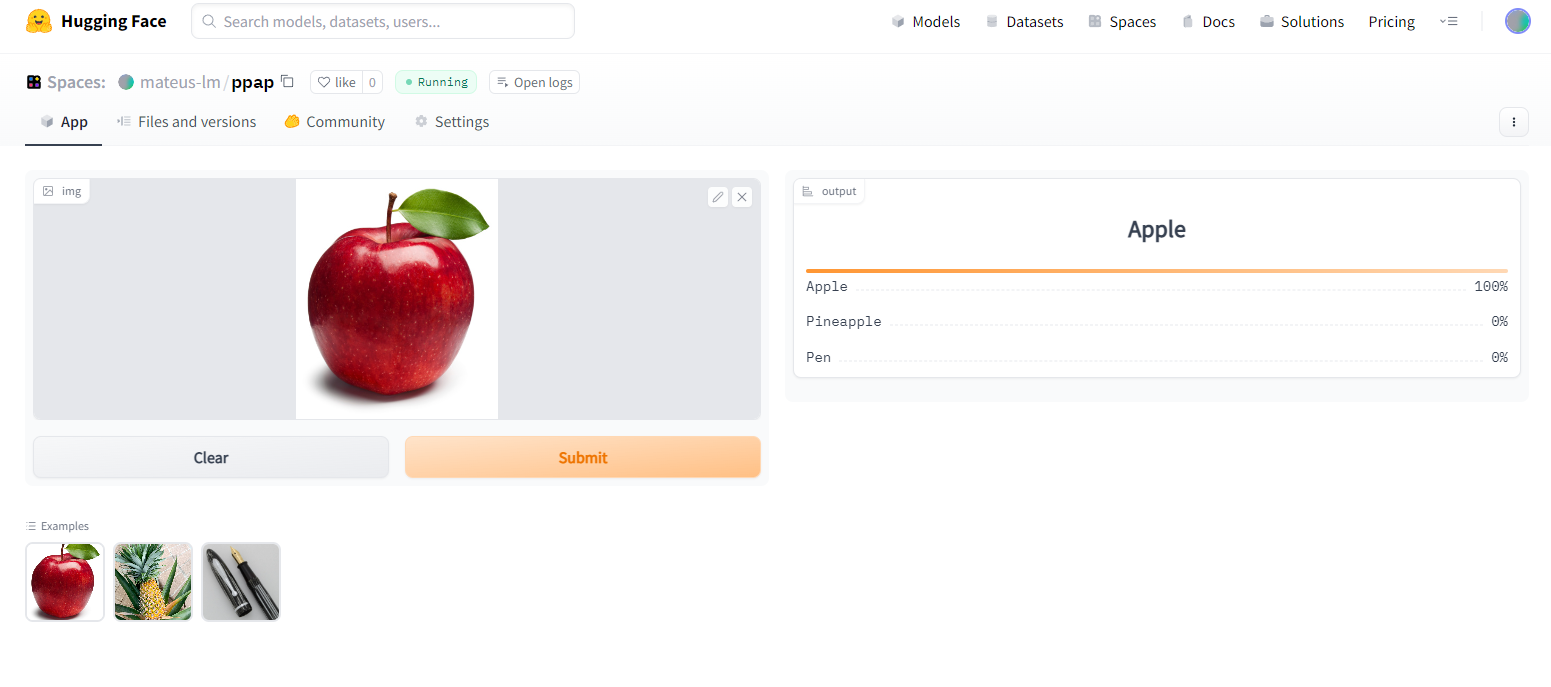

Dentro do repositório está o notebook utilizado para fazer o deploy usando o gradio.

# É isso, muito obrigado !